In [1]:
import torch
import torchvision
import os
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor
%matplotlib inline

In [2]:
import pycuda.driver as cuda
cuda.init()
## Get Id of default device
torch.cuda.current_device()
# 0
cuda.Device(0).name() # '0' is the id of your GPU

'GeForce GTX 1660 SUPER'

In [3]:
cuda.Device(0).name()

'GeForce GTX 1660 SUPER'

In [4]:
device = cuda.Device(0)

In [5]:
class ImageFolderWithPaths(torchvision.datasets.ImageFolder):
    """Custom dataset that includes image file paths. Extends
    torchvision.datasets.ImageFolder
    """

    # override the __getitem__ method. this is the method that dataloader calls
    def __getitem__(self, index):
        # this is what ImageFolder normally returns 
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        # the image file path
        path = self.imgs[index][0]
        # make a new tuple that includes original and the path
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path

In [6]:
os.listdir()

['10_year_disparities.csv',
 'poggers.ipynb',
 '.git',
 'data',
 'LICENSE',
 '.ipynb_checkpoints',
 'crop_part1.tar.gz',
 'README.md']

In [7]:
# We can use an image folder dataset the way we have it setup.
# Create the dataset
dataset = ImageFolderWithPaths(root="data/", transform=ToTensor())

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
trainset, testset = torch.utils.data.random_split(dataset, [train_size, test_size])

# Create the dataloader
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                         shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=True, num_workers=2)

In [ ]:
trainset

In [8]:
def find_gender(filename):
    demographics = filename.split("_")
    gender = int(demographics[1] )
    return gender

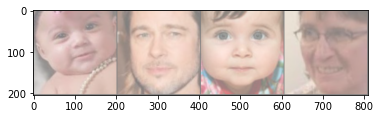

1
0
1
1


In [9]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(testloader)
images, idk, filename = dataiter.next()
# show images
imshow(torchvision.utils.make_grid(images))

for fname in filename:
    print(find_gender(fname))

In [10]:
type(device)

pycuda._driver.Device

In [15]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.cuda()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 94 * 94, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84,2)  #age (0 to 1 * 100), gender (<0.5 -> F, >=0.5 -> M), race ((0 to 1) / nraces) 

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 94 * 94)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()
net.to(torch.device("cuda:0"))
#loss_function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters())

RuntimeError: CUDA error: device-side assert triggered

In [12]:
gender_map = {}

for (i, (_, _, labels)) in enumerate(trainloader):
    for label in labels:
        gender_map[label] = find_gender(label)

In [13]:
#Training the network
for epoch in range(1):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, x, labels = data

        #getting the gender info from labels
        genders = [gender_map[label] for label in labels]

        # zero the parameter gradients
        optimizer.zero_grad()
        labels = torch.Tensor(genders)
        labels = torch.reshape(labels, (4,))

        # forward + backward + optimize
        outputs = net(inputs.cuda())

        outputs = torch.reshape(outputs, (4, ))

        loss = criterion(outputs, labels.cuda())
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 500 == 0:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.8f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

RuntimeError: CUDA error: CUBLAS_STATUS_ALLOC_FAILED when calling `cublasCreate(handle)`

In [ ]:
test_map = {}

for (i, (_, _, labels)) in enumerate(testloader):
    for label in labels:
        test_map[label] = find_gender(label)

In [ ]:
dataiter = iter(testloader)
images, something, labels = dataiter.next()
# print images
imshow(torchvision.utils.make_grid(images))
for x in labels:
    print(test_map[x])

In [ ]:
outputs = net(images.cuda())
predicted = torch.max(outputs, 1)
print(outputs)